<a href="https://colab.research.google.com/github/Abdulla-asim/DeepLearning/blob/main/Notebooks/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals
## What were going to cover

In [ ]:
# making a dictionary of what we are doing , to reference later
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to the data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading the model",
                      6: "putting it all together"
}

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.3.1+cu121'

## 1. Data (preparing and loading)

In [ ]:
# create known parameters
weight = 0.7
bias = 0.3

# create my own data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # making it torch.size([50, 1]), originally it was [50]
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets

In [ ]:
# create test/train split
train_split = int(0.8 * len(X)) # 80%
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize = (10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label="Test Data")

  if predictions is not None:
    # plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c='r', s=4, label="Preictions")

  # Show the legend
  plt.legend(prop={"size": 14})

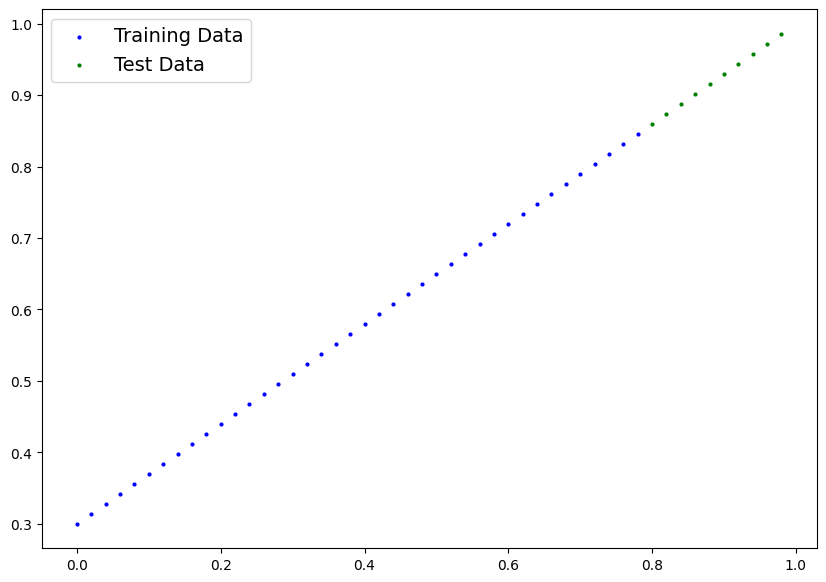

In [ ]:
plot_predictions();

## 2. Build Model

In [ ]:
# create a linear regreession model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                             requires_grad=True)

  # forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias


### checking the contents of a pytorch model

In [ ]:
# set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# create an instance of the model, (this is an instance of the nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# check the nn.Parameter(s) within the nn.Moduel subclass were created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# model state
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### making predictions with torch.inference_mode()

In [ ]:
# Make predictions with the model
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Check the predictions
print(f"length of testing sample: {len(X_test)}")
print(f"length of predictions made: {len(y_preds)}")
print(f"Predicted Values:\n{y_preds}")

length of testing sample: 10
length of predictions made: 10
Predicted Values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


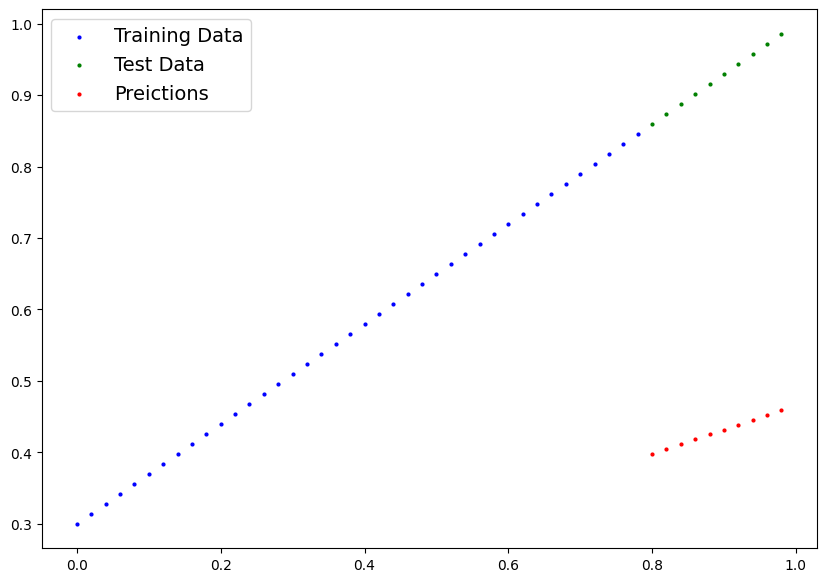

In [ ]:
plot_predictions(predictions = y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train Model

### Creating a loss function and optimizer in python

In [ ]:
# create the loss function
loss_fn = nn.L1Loss() # L1 Loss is Mean Absolute Error, MAE loss

# create the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

In [ ]:
# PyTorch train/test loop

# set a seed for reproducibility
torch.manual_seed(42)

# set the number of epochs
epochs = 200

# create empty loss lists to track values
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
  ### Training

  # Put the model in training mode
  model_0.train()

  # Forward Pass
  y_pred = model_0(X_train)

  # Calculate the Loss
  loss = loss_fn(y_pred, y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # Loss Backwards
  loss.backward()

  # progress the optimizer
  optimizer.step()

  ### Testing

  # put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # do the forward pass
    test_pred = model_0(X_test)

    # calculate the loss
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # Print the epochs
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch:3} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch:   0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch:  10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch:  20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch:  30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch:  40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch:  50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch:  60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch:  70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch:  80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch:  90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

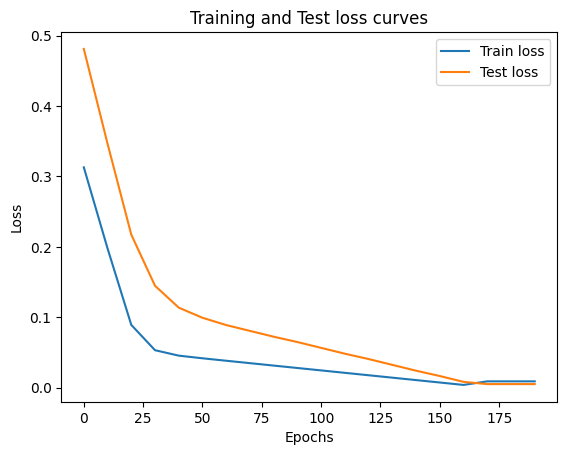

In [ ]:
# plot the loss curves
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test loss curves")
plt.legend()

In [ ]:
# Find our model's learned parameters
print(f"The model learned the following values for the weights and bias:")
print(model_0.state_dict())
print(f"\nThe original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for the weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

The original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained PyTorch model (inference)

In [ ]:
# set the model in evaluation mode
model_0.eval()

# set up the inference context manager
with torch.inference_mode():
  # make sure the model and data are on the same device
  y_preds = model_0(X_test)
y_preds


tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

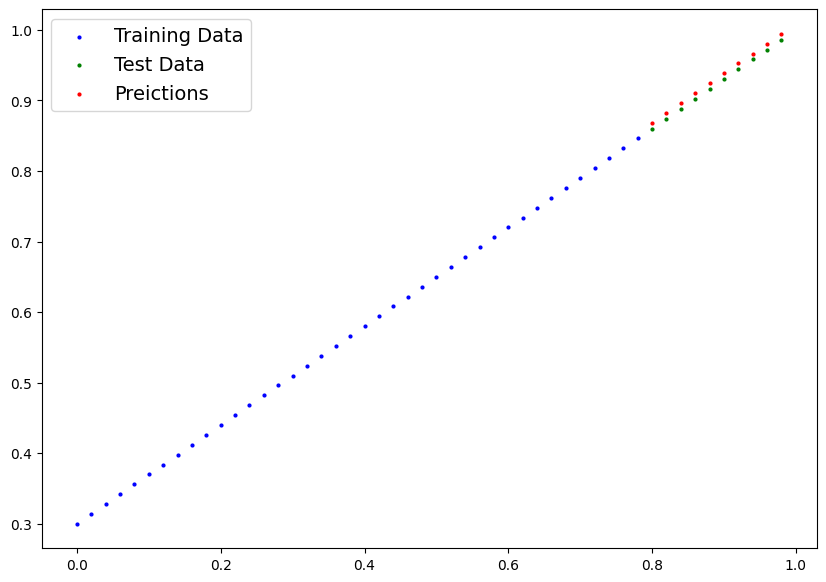

In [ ]:
plot_predictions(predictions = y_preds)

## 5. Saving and loading a PyTorch model

### Saving a PyTorch model's state_dict()

In [ ]:
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME =  "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model sate_dict()
print(f"saving model to: {MODEL_SAVE_PATH}")

torch.save(obj = model_0.state_dict(), # only saves the model's learned parameters
           f = MODEL_SAVE_PATH
           )

saving model to: Models/01_pytorch_workflow_model_0.pth


In [ ]:
# check the sved file path
!ls -l Models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Aug 16 13:40 Models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's state_dict()


In [ ]:
# instantiate a new instance of our model (it will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our model ( this will update the new instance of our model with the trained weights)
loaded_model_0.load_state_dict(torch.load("Models/01_pytorch_workflow_model_0.pth"))

<All keys matched successfully>

#### Let's perform inference with our loaded model

In [ ]:
# Put the loaded model in evaluate mode
loaded_model_0.eval()

# use the inference context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

In [ ]:
# compare previous model predictions with the loaded model
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

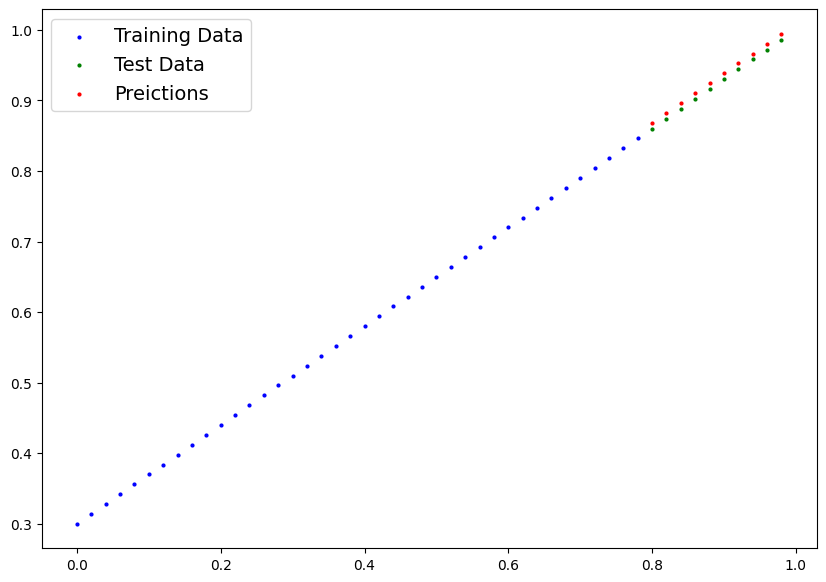

In [ ]:
plot_predictions(predictions = loaded_model_preds)

## Putting it all together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 6.1 Data

In [ ]:
# create weight and bias
weight = 0.7
bias = 0.3

# create range values
start = 0
stop = 1
step = 0.02

# create x and y (features and labels)
X = torch.arange(start, stop, step).unsqueeze(dim=1)
y = X * weight + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# split data
train_split = int(len(X) * 0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c='b', s=4, label="Train Data")
  plt.scatter(test_data, test_labels, c='g', s=4, label="Test Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  plt.legend(prop={"size": 14})

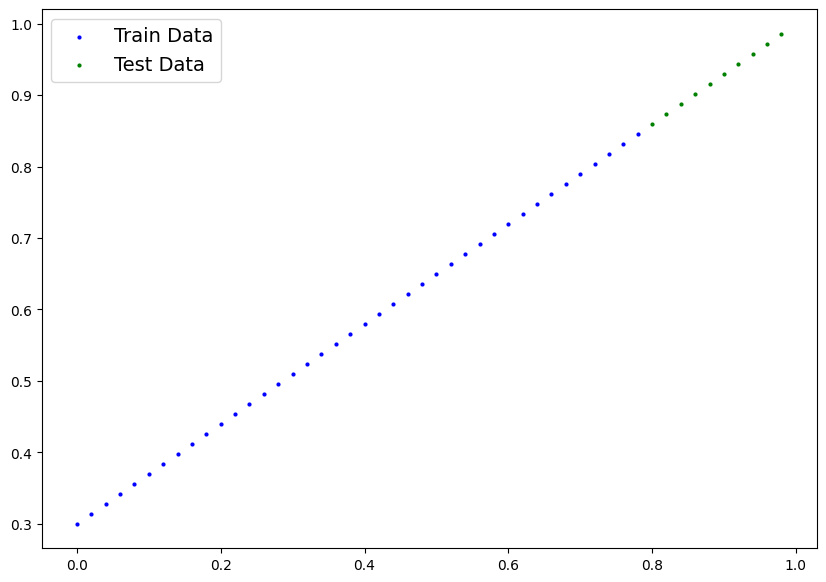

In [ ]:
plot_predictions()

### Building a PyTorch linear model

In [ ]:
# Subclass nn.Module to make our model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  # define the forward computation
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.3 Training

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch:3} | MAE Training Error: {loss:1.5} | MAE Test Error: {test_loss:1.5}")


Epoch:   0 | MAE Training Error: 0.55518 | MAE Test Error: 0.57398
Epoch: 100 | MAE Training Error: 0.0062157 | MAE Test Error: 0.014087
Epoch: 200 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 300 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 400 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 500 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 600 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 700 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 800 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802
Epoch: 900 | MAE Training Error: 0.0012645 | MAE Test Error: 0.013802


In [ ]:
# Find out model's learned parameters
from pprint import pprint
print(f"The model learned the following weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are: ")
print(f"weights: {weight}, bias: {bias}")

The model learned the following weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are: 
weights: 0.7, bias: 0.3


## 6.4 Making predictions

In [ ]:
# Put model in evaluation mode
model_1.eval()

# Do inference/predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

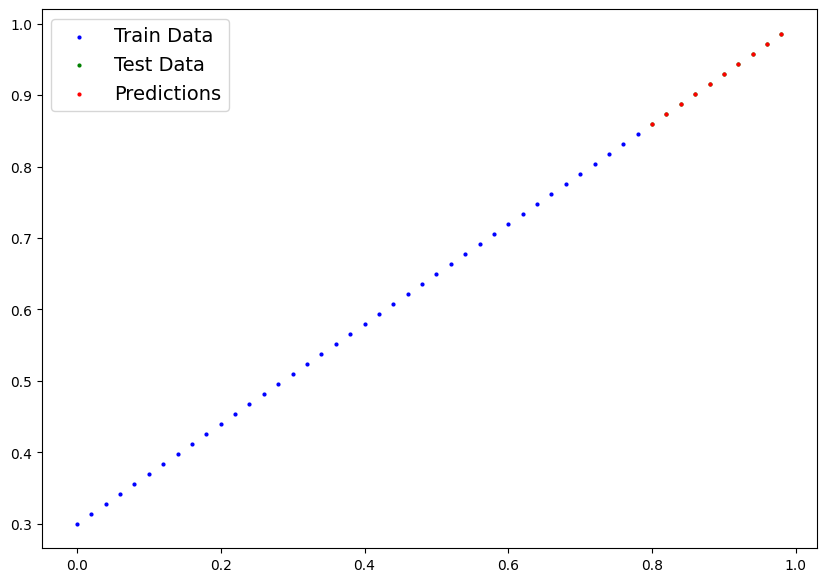

In [ ]:
plot_predictions( predictions = y_preds.cpu())

## 6.5 Saving and loading the model

In [ ]:
from pathlib import Path

# 1 create model directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2 create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODELL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3 save the model state dict
print(f"saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to : Models/01_pytorch_workflow_model_0.pth


In [ ]:

# instantiate a new instance of the LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# loading the model parameteres
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

print(f"Loaded Model: {loaded_model_1}")
print(f"Loaded Model device: {next(loaded_model_1.parameters()).device}")

Loaded Model: LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Loaded Model device: cpu


In [ ]:
# Evaluate the model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])